In [1]:
import sys
import os

SCRIPT_PATH = os.path.join(os.path.abspath(os.path.dirname('../__file__')), 'script')
sys.path.insert(0, SCRIPT_PATH)


from markov_pyactup import *
from statsmodels.formula.api import logit, glm
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)


main_dir = os.path.dirname(os.getcwd())
subject_dir = os.path.join(main_dir, 'data', 'human', '"online_data')
pr_dir = os.path.join(main_dir, 'data', 'model', 'param_recovery_0403')
opt_dir = os.path.join(main_dir, 'data', 'model', 'param_optimization_0403')

main_dir, subject_dir, opt_dir

sns.set_theme(style="white", rc={"axes.spines.right": True, "axes.spines.top": True}, font_scale=1.3)

Error trying to connect to ACT-R at 127.0.0.1 : 2651 with exception (<class 'ConnectionRefusedError'>, ConnectionRefusedError(111, 'Connection refused'), <traceback object at 0x7f0eb6541e80>)
ACT-R connection NOT established, but no exception detected or already handled.
Could not start ACT-R connection.


## Run Parameter Recovery 

In [2]:
# MarkovSimulation.simulate_param_recovery(pr_dir=pr_dir, load_opt=True, verbose=True, overwrite=False)

## Correlation

In [3]:
# ori model parameters
temp = pd.concat([pd.read_csv(f, index_col=0) for f in glob.glob(os.path.join(pr_dir, '*ori*', '*'))], axis=0)
temp_max = temp.groupby(['subject_id', 'estimate_model'])['maxLL'].max().reset_index()
df_ori = temp_max.merge(temp, how='inner').melt(id_vars=['subject_id', 'estimate_model'], var_name='param_name', value_name='param_value').sort_values(by = ['subject_id', 'estimate_model'])
df_ori.head()

,subject_id,estimate_model,param_name,param_value
0,1,markov-ibl-hybrid,maxLL,-268.9632
302,1,markov-ibl-hybrid,alpha,0.9320
604,1,markov-ibl-hybrid,beta,2.2464
906,1,markov-ibl-hybrid,lambda_parameter,0.3731
1208,1,markov-ibl-hybrid,p_parameter,0.0000


In [4]:
# recovered model parameters
df_list = []
for ori_model in ['markov-rl-hybrid', 'markov-ibl-hybrid']:
    temp = pd.concat([pd.read_csv(f, index_col=0) for f in glob.glob(os.path.join(pr_dir, '*rec*', ori_model, '*'))], axis=0)
    temp_max = temp.groupby(['subject_id', 'estimate_model'])['maxLL'].max().reset_index()
    temp = temp_max.merge(temp, how='inner')
    temp = temp.rename({'estimate_model':'estimate_model.rec'}, axis=1).melt(id_vars=['subject_id', 'estimate_model.rec'], var_name='param_name', value_name='param_value').sort_values(by = ['subject_id', 'estimate_model.rec', 'param_name'])
    temp['estimate_model']=ori_model
    df_list.append(temp)
df_rec = pd.concat(df_list, axis=0)

In [5]:
# combine ori and reco
dfm = pd.merge(df_ori, df_rec, on=['subject_id', 'param_name', 'estimate_model'], suffixes=('.ori', '.rec')).drop_duplicates().rename({'estimate_model':'estimate_model.ori'}, axis=1)
dfm.head()

,subject_id,estimate_model.ori,param_name,param_value.ori,estimate_model.rec,param_value.rec
0,1,markov-ibl-hybrid,maxLL,-268.9632,markov-ibl-hybrid,-276.2944
1,1,markov-ibl-hybrid,maxLL,-268.9632,markov-rl-hybrid,-274.9072
5,1,markov-ibl-hybrid,beta,2.2464,markov-ibl-hybrid,3.0677
6,1,markov-ibl-hybrid,beta,2.2464,markov-rl-hybrid,0.479
7,1,markov-ibl-hybrid,beta,2.2464,markov-rl-hybrid,0.4791


In [6]:
len(dfm.subject_id.unique())

151

In [7]:
dfm1 = dfm[(dfm['estimate_model.ori']=='markov-rl-hybrid') & (dfm['estimate_model.ori']=='markov-rl-hybrid')].convert_dtypes()
dfm2 = dfm[(dfm['estimate_model.ori']=='markov-ibl-hybrid') & (dfm['estimate_model.ori']=='markov-ibl-hybrid')]
dfm1.head()

,subject_id,estimate_model.ori,param_name,param_value.ori,estimate_model.rec,param_value.rec
45,1,markov-rl-hybrid,maxLL,-264.9156,markov-ibl-hybrid,-273.0308
46,1,markov-rl-hybrid,maxLL,-264.9156,markov-rl-hybrid,-269.1728
52,1,markov-rl-hybrid,beta,1.0047,markov-ibl-hybrid,1.4539
53,1,markov-rl-hybrid,beta,1.0047,markov-rl-hybrid,0.8283
54,1,markov-rl-hybrid,beta,1.0047,markov-rl-hybrid,0.8


/home/chery/.conda/envs/pyactrr/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


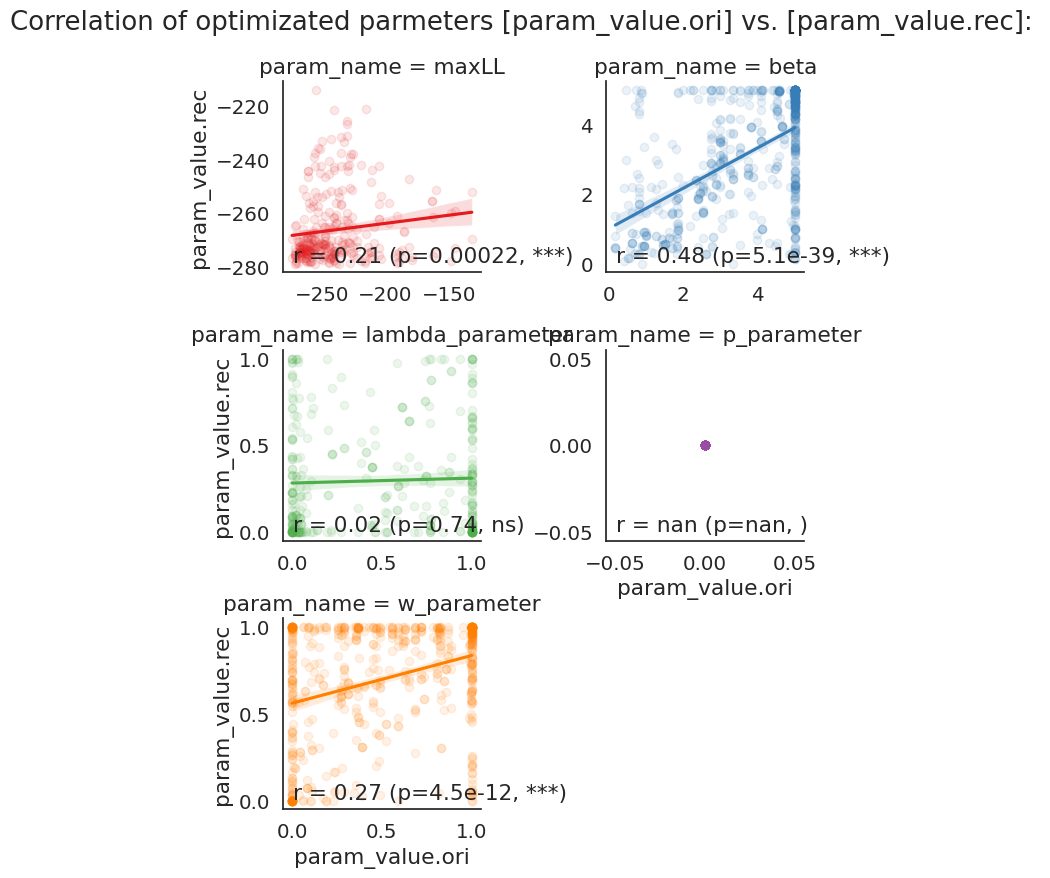

In [8]:
dfm1['param_value.ori'] = dfm1['param_value.ori'].astype('float32')
dfm1['param_value.rec'] = dfm1['param_value.rec'].astype('float32')
MarkovPlot.parameter_lm_plot(df=dfm1, x_name='param_value.ori', y_name='param_value.rec', exclude_parameters=['temperature', 'decay', 'lf', 'fixed_cost'], alpha=.1)

/tmp/ipykernel_17897/3097935366.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm2['param_value.ori'] = np.array(dfm2['param_value.ori'], dtype=float)
/tmp/ipykernel_17897/3097935366.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm2['param_value.rec'] = np.array(dfm2['param_value.rec'], dtype=float)


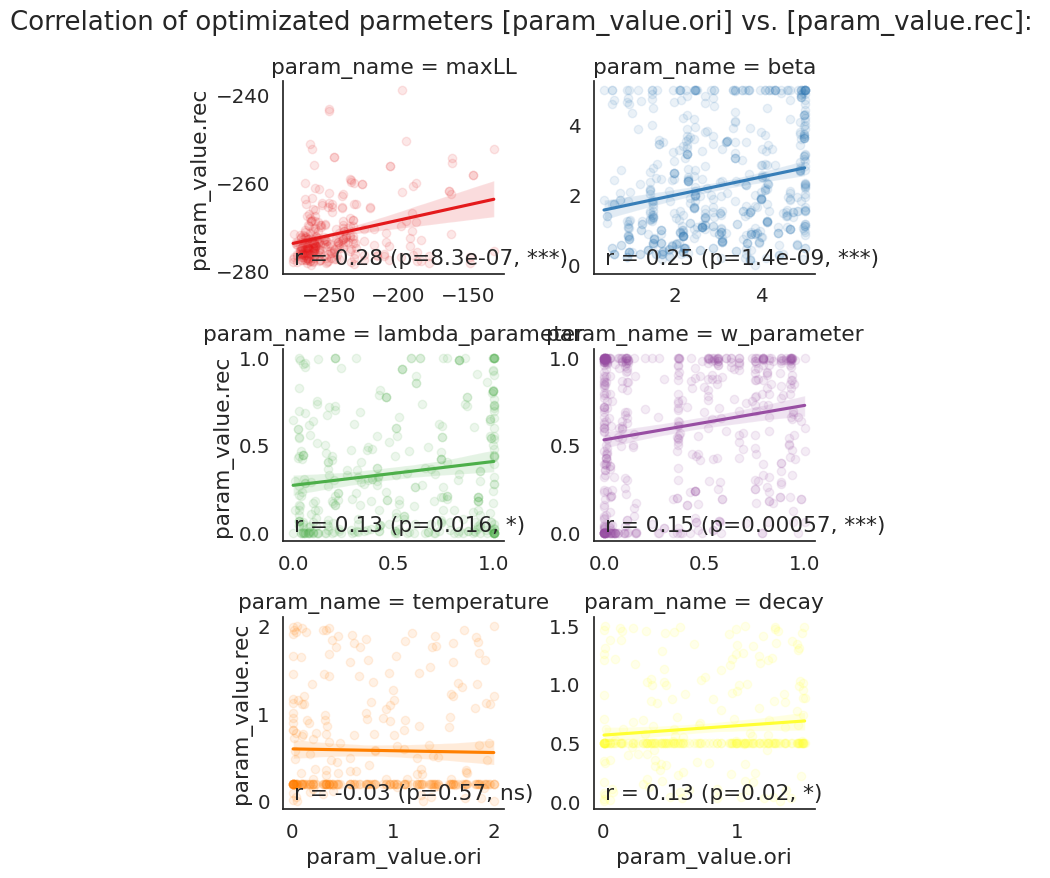

In [9]:
dfm2['param_value.ori'] = np.array(dfm2['param_value.ori'], dtype=float)
dfm2['param_value.rec'] = np.array(dfm2['param_value.rec'], dtype=float)
MarkovPlot.parameter_lm_plot(df=dfm2, x_name='param_value.ori', y_name='param_value.rec', exclude_parameters=['p_parameter', 'lf', 'fixed_cost'], alpha=.1)

In [10]:
# df_ori = pd.concat([pd.read_csv(f, index_col=0) for f in glob.glob(os.path.join(pr_dir, '*ori*', '*'))], axis=0).melt(id_vars=['subject_id', 'estimate_model'], var_name='param_name', value_name='param_value').sort_values(by = ['subject_id', 'estimate_model'])
# df_rec = pd.concat([pd.read_csv(f, index_col=0) for f in glob.glob(os.path.join(pr_dir, '*rec*', '*', '*'))], axis=0).melt(id_vars=['subject_id', 'estimate_model'], var_name='param_name', value_name='param_value').sort_values(by = ['subject_id', 'estimate_model'])

In [11]:
# dfm1 = pd.merge(df_ori[df_ori['estimate_model']=='markov-rl-hybrid'], df_rec[df_rec['estimate_model']=='markov-rl-hybrid'], 
#          on=['subject_id', 'param_name', 'estimate_model'], suffixes=('.ori', '.rec')).drop_duplicates()
# dfm2 = pd.merge(df_ori[df_ori['estimate_model']=='markov-ibl-hybrid'], df_rec[df_rec['estimate_model']=='markov-ibl-hybrid'],
#          on=['subject_id', 'param_name', 'estimate_model'], suffixes=('.ori', '.rec'))